<a href="https://colab.research.google.com/github/dakshnpci/NPCIMLTraining/blob/master/Titanic_NeuralNetworkGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


In [0]:
# Load data as Pandas dataframe
train = pd.read_csv('https://raw.githubusercontent.com/dakshnpci/NPCIMLTraining/master/train_clean.csv', )
test = pd.read_csv('https://raw.githubusercontent.com/dakshnpci/NPCIMLTraining/master/test_clean.csv')
df = pd.concat([train, test], axis=0)

In [11]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


In [12]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1309,NaN,NaN,NaN,33.2762,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [0]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [0]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [15]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
df.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Family_Size,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,7.2500,0,3,1,1,0.0,1,0,0,1,0,0,0,1,0,0
1,38.0,71.2833,0,1,0,1,1.0,1,1,0,0,0,0,0,0,1,0
2,26.0,7.9250,0,3,0,0,1.0,0,0,0,1,0,0,1,0,0,0
3,35.0,53.1000,0,1,0,1,1.0,1,0,0,1,0,0,0,0,1,0
4,35.0,8.0500,0,3,1,0,0.0,0,0,0,1,0,0,0,1,0,0


In [0]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [17]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,7.327981e-17,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Fare,1309.0,2.171254e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,1.730218e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-2.062691e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-1.628440e-17,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Family_Size,1309.0,1.628440e-17,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


In [0]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

In [49]:
#@title
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/880/1*tldIgyDQWqm-sMwP7m3Bww.png")

In [50]:
#@title


from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/880/1*Xu7B5y9gp0iL5ooBj7LtWw.png")

In [0]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_random_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [21]:
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_acc'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 86.61%


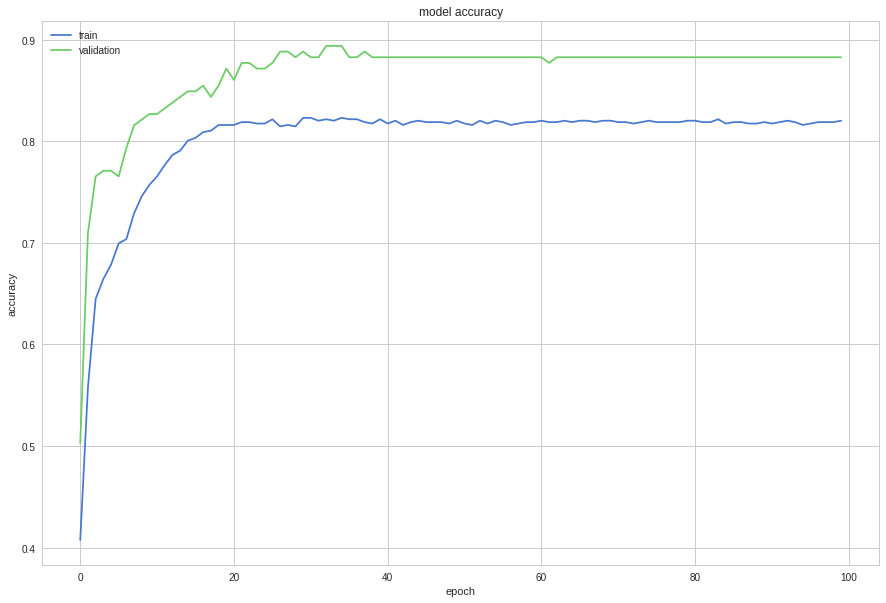

In [23]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] batch_size=16, epochs=50 ........................................
[CV] ......................... batch_size=16, epochs=50, total=   9.3s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ......................... batch_size=16, epochs=50, total=   9.4s
[CV] batch_size=16, epochs=50 ........................................
[CV] ......................... batch_size=16, epochs=50, total=   9.4s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=  18.1s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=  18.2s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=  18.1s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   5.2s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   5.4s
[CV] batch_size=32, epochs=50 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.6min finished


In [25]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818182 using {'batch_size': 64, 'epochs': 100}
0.817059 (0.012992) with: {'batch_size': 16, 'epochs': 50}
0.814815 (0.014547) with: {'batch_size': 16, 'epochs': 100}
0.815937 (0.011111) with: {'batch_size': 32, 'epochs': 50}
0.813692 (0.018305) with: {'batch_size': 32, 'epochs': 100}
0.814815 (0.014285) with: {'batch_size': 64, 'epochs': 50}
0.818182 (0.011983) with: {'batch_size': 64, 'epochs': 100}


In [26]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   5.0s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] .......................................... opt=SGD, total=   5.1s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   5.2s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.9s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.8s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.8s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   5.6s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   5.8s
[CV] opt=Adagrad .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.9min finished


In [27]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822671 using {'opt': 'RMSprop'}
0.805836 (0.016798) with: {'opt': 'SGD'}
0.822671 (0.011111) with: {'opt': 'RMSprop'}
0.813692 (0.011111) with: {'opt': 'Adagrad'}
0.821549 (0.011983) with: {'opt': 'Adadelta'}
0.815937 (0.011111) with: {'opt': 'Adam'}
0.817059 (0.015141) with: {'opt': 'Nadam'}


In [28]:
seed(42)
set_random_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   7.5s
[CV] lyrs=[8] ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ......................................... lyrs=[8], total=   7.6s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   8.2s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   7.8s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   7.9s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   8.0s
[CV] lyrs=[10, 5] ....................................................
[CV] ..................................... lyrs=[10, 5], total=   8.8s
[CV] lyrs=[10, 5] ....................................................
[CV] ..................................... lyrs=[10, 5], total=   9.0s
[CV] lyrs=[10, 5] ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.2min finished


In [29]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.824916 using {'lyrs': [12, 8, 4]}
0.815937 (0.011111) with: {'lyrs': [8]}
0.821549 (0.009912) with: {'lyrs': [10]}
0.822671 (0.016109) with: {'lyrs': [10, 5]}
0.822671 (0.013561) with: {'lyrs': [12, 6]}
0.824916 (0.017168) with: {'lyrs': [12, 8, 4]}


In [30]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dr=0.0 ..........................................................
[CV] ........................................... dr=0.0, total=   9.0s
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ........................................... dr=0.0, total=   9.7s
[CV] dr=0.0 ..........................................................
[CV] ........................................... dr=0.0, total=   9.8s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=  10.1s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=  10.1s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=  10.3s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=  10.4s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=  11.1s
[CV] dr=0.05 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.2min finished


In [31]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.823793 using {'dr': 0.05}
0.815937 (0.011111) with: {'dr': 0.0}
0.822671 (0.018305) with: {'dr': 0.01}
0.823793 (0.019888) with: {'dr': 0.05}
0.821549 (0.019047) with: {'dr': 0.1}
0.820426 (0.019888) with: {'dr': 0.2}
0.813692 (0.016798) with: {'dr': 0.5}


In [35]:
# create final model
# model = create_model(lyrs=[8], dr=0.2)
model = create_model(lyrs=[12, 8, 4],  opt='RMSprop', dr=0.05)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 12)                204       
_________________________________________________________________
dense_167 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_168 (Dense)            (None, 4)                 36        
_________________________________________________________________
dropout_76 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 5         
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=64, batch_size=100, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

891/891 [==============================] - 0s 93us/step

acc: 86.31%


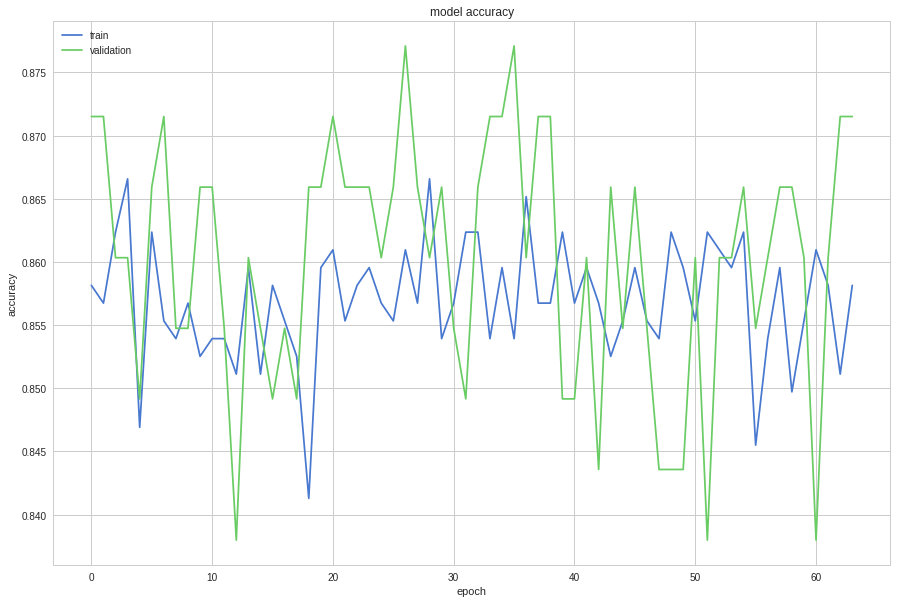

In [46]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()